In [1]:
# Paquetes
import pandas as pd
import numpy as np
import boto3
import os
from datetime import datetime, timedelta
import dateutil.relativedelta
import gc

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',400)

In [2]:
def get_s3_files(s3_url):
    session = boto3.session.Session()
    s3 = session.client("s3")
    bucket = s3_url.split("/")[2]
    key = s3_url.split("/")[3:]
    key = "/".join(key)
    objects = _key_files__list(s3, bucket, key)
    files = ["s3://" + bucket + "/" + file["Key"] for file in objects]
    return files

def _key_files__list(client, bucket, key):
    """return the key's size if it exist, else None"""
    response = client.list_objects_v2(Bucket=bucket, Prefix=key)
    return response.get("Contents", [])

In [2]:
path = 's3://data-bpop-dev-sandbox-de/campana_mkd/click_to_call/clic_to_call_detalle_H20200901_20201018.csv'
data = pd.read_csv(path, encoding='latin-1')
data.head()

,date,numero_identificacion,total_tarjetas,channel,grupo_prob,segmento,channel_modificado
0,2020-10-07,10159126,1,atento,grupo_prob_baja,seg_preaprobado,atento
1,2020-09-21,10159462,1,oficina,grupo_prob_alta,seg_preaprobado,oficina
2,2020-10-06,10214423,1,atento,grupo_prob_baja,seg_preaprobado,atento
3,2020-10-16,10347708,1,atento,grupo_prob_alta,seg_preaprobado,atento
4,2020-10-09,10530015,1,atento,grupo_prob_alta,seg_preaprobado,atento


In [10]:
data["date"]  = pd.to_datetime(data["date"], format='%Y-%m-%d')
data["month"] = data["date"].dt.to_period("M")
data.month.value_counts()

2020-10    164
2020-09     43
Freq: M, Name: month, dtype: int64

In [20]:
data.groupby(['segmento','grupo_prob']).size()

segmento         grupo_prob     
seg_perfilado    grupo_prob_alta      6
                 grupo_prob_baja      2
seg_preaprobado  grupo_prob_alta     95
                 grupo_prob_baja    104
dtype: int64

In [5]:
data.total_tarjetas.sum()

239

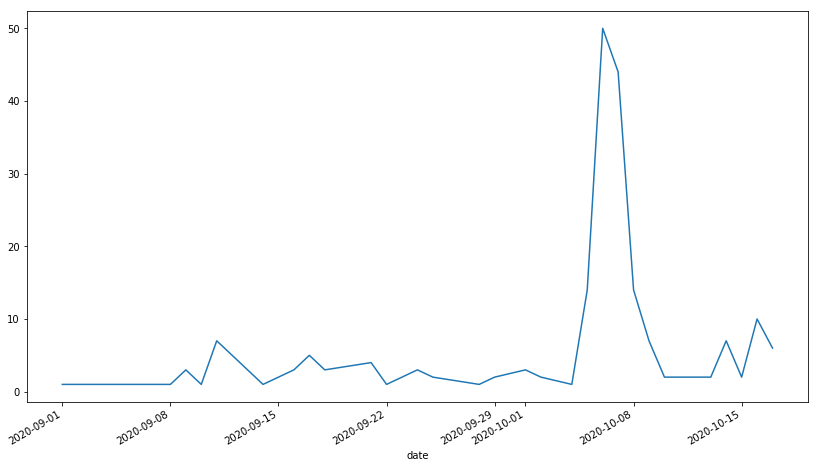

In [17]:
data.groupby('date').size().plot(figsize=(14,8))

In [27]:
data.month.value_counts()

2020-10    164
2020-09     43
Freq: M, Name: month, dtype: int64

In [28]:
octubre = data[data["month"]=='2020-10']

In [29]:
octubre.groupby(['segmento','grupo_prob']).size()

segmento         grupo_prob     
seg_perfilado    grupo_prob_alta     2
                 grupo_prob_baja     2
seg_preaprobado  grupo_prob_alta    71
                 grupo_prob_baja    89
dtype: int64

In [31]:
data.numero_identificacion.value_counts()

20472831      1
79496865      1
37218997      1
36532353      1
41307955      1
20437299      1
79420079      1
40176814      1
8389146       1
2570485       1
19244200      1
41645732      1
3294365       1
78024376      1
31578570      1
8665217       1
18106009      1
3110040       1
27358981      1
8226448       1
94286871      1
79120011      1
24307336      1
17051783      1
91183643      1
11785404      1
38940803      1
38246621      1
26309813      1
32421107      1
19176690      1
1068926190    1
1120359299    1
18124522      1
66944229      1
9090173       1
35458786      1
12365023      1
43608282      1
17146046      1
91242201      1
52062417      1
9075142       1
57436366      1
30020301      1
20937420      1
39809340      1
1064137       1
6286717       1
30726847      1
42492037      1
12268161      1
9063158       1
17346184      1
79642682      1
41707062      1
10347708      1
66910254      1
17800235      1
17623081      1
17086504      1
23247398      1
41398811

## Analizando Base Septiembre - Oct - Nov

In [27]:
import s3fs
import pyarrow as pa
import pyarrow.parquet as pq

def spark_read_parquet(s3_url: str, **args):
    fs = s3fs.S3FileSystem()
    # Leyendo base
    dataset = pq.ParquetDataset(s3_url, filesystem=fs)
    table = dataset.read()
    dataframe = table.to_pandas()

    del dataset, table

    return dataframe

fs = s3fs.S3FileSystem()

In [28]:
## Cargando campañas

path = 's3://adl-refined-dev-popular/parquet/TC_adquisicion/data_camp_act_M202111'

base_camp = spark_read_parquet(path)
base_camp = base_camp.rename(columns={'cedula':'id_numero_cliente'})

base_camp.head()

,id_numero_cliente,mes_campaña,acep_oferta_prev,mes_ult_act,mes_ult_camp,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_actv,num_meses_ult_camp,num_no_aceptado,data_camp,no_nulos
0,7330974,2019-04-01,0.0,NaT,2019-02-01,0.0,1.0,NaN,1.966667,1.0,202110,2
1,3178728,2019-04-01,0.0,NaT,2019-02-01,0.0,1.0,NaN,1.966667,1.0,202110,2
2,12715964,2019-06-01,0.0,NaT,2019-02-01,0.0,1.0,NaN,4.000000,1.0,202110,2
3,22127768,2019-06-01,0.0,NaT,2019-01-01,0.0,1.0,NaN,5.033333,1.0,202110,2
4,13823706,2019-06-01,0.0,NaT,2019-01-01,0.0,1.0,NaN,5.033333,1.0,202110,2


In [29]:
base_camp.dtypes

id_numero_cliente              int64
mes_campaña                   object
acep_oferta_prev             float64
mes_ult_act           datetime64[ns]
mes_ult_camp          datetime64[ns]
num_act_utl_meses            float64
num_camp_ult_meses           float64
num_meses_ult_actv           float64
num_meses_ult_camp           float64
num_no_aceptado              float64
data_camp                      int64
no_nulos                       int64
dtype: object

In [30]:
paths_salidas = get_s3_files('s3://adl-refined-dev-popular/parquet/TC_adquisicion')
paths_salidas = list(pd.Series(paths_salidas)[pd.Series(paths_salidas).str.contains('propension-tc_preaprob_M')])
paths_salidas

['s3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210305.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210318',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210318.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210419.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210520.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210616.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210713.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210811.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210914.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20211014.csv',
 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preapr

In [31]:
## Cargando base anterior
path = 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20210914.csv'


base_ant_sep = pd.read_csv(path, sep='|', dtype={'id_cliente':str,
                                            'id_numero_cliente':int,})
base_ant_sep.head()

,id_cliente,id_numero_cliente,score,decil,nivel_prob
0,102652295584838601,11439693,0.002469,1,Bajo
1,102652297314584801,23823293,0.002469,1,Bajo
2,102652303931898101,78746146,0.011474,1,Bajo
3,102652296820136301,20300762,0.004604,1,Bajo
4,102652295962567901,14235210,0.002469,1,Bajo


In [32]:
## Cargando base anterior
path = 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20211014.csv'


base_ant_oct = pd.read_csv(path, sep='|', dtype={'id_cliente':str,
                                            'id_numero_cliente':int,})
base_ant_oct.head()

,id_cliente,id_numero_cliente,score,decil,nivel_prob,num_meses_ult_camp,camp_anteriores,grupo_camp
0,102652295880533801,13544804,0.030755,3,Medio,NaN,No Tocado,3
1,102652297335747101,24176168,0.002469,1,Bajo,NaN,No Tocado,1
2,102652294446682301,2485304,0.074669,5,Alto,NaN,No Tocado,3
3,102652302876755501,51910738,0.002469,1,Bajo,NaN,No Tocado,1
4,102652304311321301,80068668,0.002469,1,Bajo,NaN,No Tocado,1


In [33]:
## Cargando base anterior
path = 's3://adl-refined-dev-popular/parquet/TC_adquisicion/propension-tc_preaprob_M20211112.csv'


base_ant_nov = pd.read_csv(path, sep='|', dtype={'id_cliente':str,
                                            'id_numero_cliente':int,})
base_ant_nov.head()

,id_cliente,id_numero_cliente,score,decil,nivel_prob,num_meses_ult_camp,camp_anteriores,grupo_camp
0,102652295880533801,13544804,0.076767,5,Alto,NaN,No Tocado,3
1,102652295151150201,6880226,0.029480,3,Medio,NaN,No Tocado,3
2,102652314595088801,41311613,0.014120,2,Medio Bajo,NaN,No Tocado,1
3,102652308842687701,36695801,0.014040,2,Medio Bajo,NaN,No Tocado,1
4,103552297266851902,23173372,0.009694,1,Bajo,NaN,No Tocado,1


In [34]:
print(base_ant_sep.shape)
base_ant_sep = pd.merge(base_ant_sep, base_camp, on=['id_numero_cliente'], how='left')
print(base_ant_sep.shape)

print(base_ant_oct.shape)
base_ant_oct = pd.merge(base_ant_oct, base_camp[['id_numero_cliente','num_no_aceptado']], on=['id_numero_cliente'], how='left')
print(base_ant_oct.shape)

print(base_ant_nov.shape)
base_ant_nov = pd.merge(base_ant_nov, base_camp[['id_numero_cliente','num_no_aceptado']], on=['id_numero_cliente'], how='left')
print(base_ant_nov.shape)

base_ant_nov.head()

(1043342, 5)
(1043342, 16)
(1046016, 8)
(1046016, 9)
(326740, 8)
(326740, 9)


,id_cliente,id_numero_cliente,score,decil,nivel_prob,num_meses_ult_camp,camp_anteriores,grupo_camp,num_no_aceptado
0,102652295880533801,13544804,0.076767,5,Alto,NaN,No Tocado,3,NaN
1,102652295151150201,6880226,0.029480,3,Medio,NaN,No Tocado,3,NaN
2,102652314595088801,41311613,0.014120,2,Medio Bajo,NaN,No Tocado,1,NaN
3,102652308842687701,36695801,0.014040,2,Medio Bajo,NaN,No Tocado,1,NaN
4,103552297266851902,23173372,0.009694,1,Bajo,NaN,No Tocado,1,NaN


In [35]:
paths = get_s3_files('s3://data-bpop-dev-sandbox/landing/tmp/')
paths = list(pd.Series(paths)[pd.Series(paths).str.contains('TC_PREAPROBADOS')])
paths

['s3://data-bpop-dev-sandbox/landing/tmp/tmpg_BASE_FINAL_TC_PREAPROBADOS_SEPTIEMBRE.xlsx',
 's3://data-bpop-dev-sandbox/landing/tmp/tmpg_TC_PREAPROBADOS-OCT-NOV.xlsx']

In [36]:
#path = 's3://data-bpop-dev-sandbox/landing/tmp/tmpg_BASE_FINAL_TC_PREAPROBADOS_SEPTIEMBRE.xlsx'
path = paths[0]

# , names=None, index_col=None, usecols=None, squeeze=False, dtype=None, engine=None, converters=None, true_values=None, 
# false_values=None, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, 
# parse_dates=False, date_parser=None, thousands=None, comment=None, skipfooter=0, convert_float=None, mangle_dupe_cols=True, 
# storage_options=None

base_sep = pd.read_excel(path, sheet_name=0, header=0, dtype={'num_doc':int})
base_sep.columns = base_sep.columns.str.lower()
base_sep = base_sep.rename(columns={'num_doc':'id_numero_cliente'})
base_sep.head()


,tip_doc,id_numero_cliente,canal
0,2,93442,ATENTO
1,2,96681,ATENTO
2,1,193093,ATENTO
3,1,194243,ATENTO
4,1,217974,ATENTO


In [37]:
## Oct - Nov
path = paths[1]

base_oct_nov = pd.read_excel(path, sheet_name=0, header=0, dtype={'num_doc':int})
base_oct_nov.columns = base_oct_nov.columns.str.lower()
base_oct_nov = base_oct_nov.rename(columns={'num_doc':'id_numero_cliente'})

## base octubre
base_oct = base_oct_nov[base_oct_nov['mes'] == 'OCTUBRE']
## base Noviembre
base_nov = base_oct_nov[base_oct_nov['mes'] == 'NOVIEMBRE']


In [38]:
base_oct_nov['mes'].value_counts()

NOVIEMBRE    9979
OCTUBRE      8931
Name: mes, dtype: int64

In [39]:
base_union_sep = pd.merge(base_sep, base_ant_sep, on=['id_numero_cliente'], how='left')
base_union_sep['id_cliente'] = base_union_sep['id_cliente'].fillna('0').astype('int')
print(base_ant_sep.shape)
print(base_sep.shape)
print(base_union_sep.shape)
base_union_sep.head()

(1043342, 16)
(9743, 3)
(9745, 18)


,tip_doc,id_numero_cliente,canal,id_cliente,score,decil,nivel_prob,mes_campaña,acep_oferta_prev,mes_ult_act,mes_ult_camp,num_act_utl_meses,num_camp_ult_meses,num_meses_ult_actv,num_meses_ult_camp,num_no_aceptado,data_camp,no_nulos
0,2,93442,ATENTO,633252309030673101,0.003815,1.0,Bajo,2021-09-01,0.0,NaT,2021-04-01,0.0,3.0,NaN,5.1,3.0,202110.0,2.0
1,2,96681,ATENTO,822353263230729301,0.016874,2.0,Medio Bajo,2021-09-01,0.0,NaT,2021-05-01,0.0,2.0,NaN,4.1,2.0,202110.0,2.0
2,1,193093,ATENTO,367155266520940202,0.006045,1.0,Bajo,2021-09-01,0.0,NaT,2020-08-01,0.0,1.0,NaN,13.2,1.0,202110.0,2.0
3,1,194243,ATENTO,504260104654094902,0.006028,1.0,Bajo,2021-09-01,0.0,NaT,2021-04-01,0.0,1.0,NaN,5.1,1.0,202110.0,2.0
4,1,217974,ATENTO,476953298350833902,0.059116,4.0,Alto,2021-09-01,0.0,NaT,2021-05-01,0.0,4.0,NaN,4.1,4.0,202110.0,2.0


In [40]:
base_union_oct = pd.merge(base_oct, base_ant_oct, on=['id_numero_cliente'], how='left')
base_union_oct['id_cliente'] = base_union_oct['id_cliente'].fillna('0').astype('int')
print(base_ant_oct.shape)
print(base_oct.shape)
print(base_union_oct.shape)
base_union_oct.head()

(1046016, 9)
(8931, 4)
(8931, 12)


,tip_doc,id_numero_cliente,canal,mes,id_cliente,score,decil,nivel_prob,num_meses_ult_camp,camp_anteriores,grupo_camp,num_no_aceptado
0,1,22632854,ATENTO,OCTUBRE,702552306336179801,0.006592,1.0,Bajo,9.200000,Tocado,2.0,1.0
1,1,28533142,ATENTO,OCTUBRE,336052308007054202,0.004952,1.0,Bajo,4.000000,Tocado,2.0,2.0
2,1,78754740,ATENTO,OCTUBRE,117152314023210701,0.005546,1.0,Bajo,NaN,No Tocado,1.0,1.0
3,1,41725413,ATENTO,OCTUBRE,798452299225277802,0.003920,1.0,Bajo,5.033333,Tocado,2.0,1.0
4,1,10221339,ATENTO,OCTUBRE,455552295473889701,0.007655,1.0,Bajo,4.000000,Tocado,2.0,3.0


In [41]:
base_union_nov = pd.merge(base_nov, base_ant_nov, on=['id_numero_cliente'], how='left')
base_union_nov['id_cliente'] = base_union_nov['id_cliente'].fillna('0').astype('int')
print(base_ant_nov.shape)
print(base_nov.shape)
print(base_union_nov.shape)
base_union_nov.head()

(326740, 9)
(9979, 4)
(9979, 12)


,tip_doc,id_numero_cliente,canal,mes,id_cliente,score,decil,nivel_prob,num_meses_ult_camp,camp_anteriores,grupo_camp,num_no_aceptado
0,1,3068589,ATENTO,NOVIEMBRE,387252313667540702,0.244072,5.0,Alto,NaN,No Tocado,3.0,NaN
1,1,16342052,ATENTO,NOVIEMBRE,851852305732864802,0.054856,4.0,Alto,NaN,No Tocado,3.0,NaN
2,1,39693028,ATENTO,NOVIEMBRE,414355242628140301,0.218896,5.0,Alto,NaN,No Tocado,3.0,NaN
3,1,26490417,ATENTO,NOVIEMBRE,576752297516552001,0.209247,5.0,Alto,NaN,No Tocado,3.0,NaN
4,1,19263565,ATENTO,NOVIEMBRE,364560493867617706,0.228388,5.0,Alto,NaN,No Tocado,3.0,NaN


In [42]:
#base_union.to_csv('base.csv', sep='|')

In [43]:
base_union_sep['camp_anteriores'] = np.where(base_union_sep['num_meses_ult_camp'] > 0, 'Tocado', 'No Tocado')

In [44]:
pd.crosstab(base_union_sep['nivel_prob'], base_union_sep['camp_anteriores'])

camp_anteriores,No Tocado,Tocado
nivel_prob,,
Alto,462,1846
Bajo,742,3325
Medio,390,769
Medio Bajo,845,1349


In [45]:
pd.crosstab(base_union_oct['nivel_prob'], base_union_oct['camp_anteriores'])

camp_anteriores,No Tocado,Tocado
nivel_prob,,
Alto,672,1166
Bajo,1472,3081
Medio,403,562
Medio Bajo,571,995


In [46]:
pd.crosstab(base_union_nov['nivel_prob'], base_union_nov['camp_anteriores'])

camp_anteriores,No Tocado,Tocado
nivel_prob,,
Alto,2346,411
Bajo,2190,1262
Medio,1404,334
Medio Bajo,1292,543


In [47]:
base_union_sep['num_no_aceptado'].value_counts()

1.0    1943
2.0    1561
4.0    1426
3.0    1185
5.0     687
6.0     245
7.0     196
8.0      44
0.0       2
Name: num_no_aceptado, dtype: int64

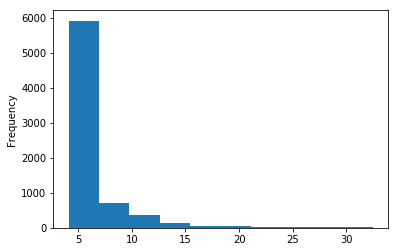

In [48]:
base_union_sep['num_meses_ult_camp'].plot.hist()

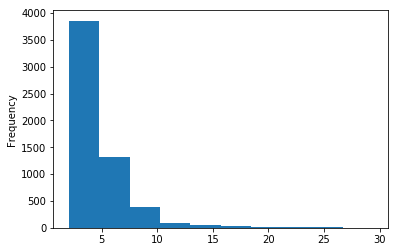

In [49]:
base_union_oct['num_meses_ult_camp'].plot.hist()

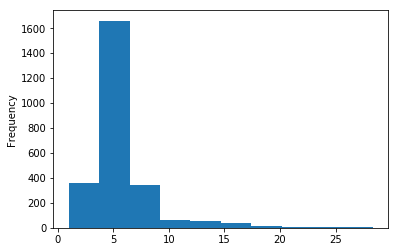

In [50]:
base_union_nov['num_meses_ult_camp'].plot.hist()

Promedio de no aceptados: 2.8746055700370423


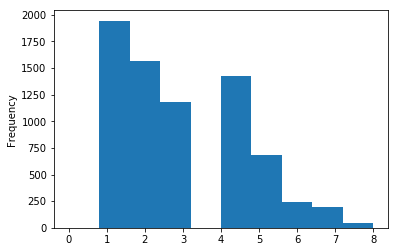

In [51]:
## De los tocados:
print("Promedio de no aceptados:",base_union_sep['num_no_aceptado'].mean())
base_union_sep['num_no_aceptado'].plot.hist()

Promedio de no aceptados: 2.598102766798419


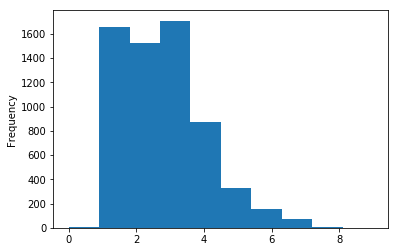

In [52]:
## De los tocados:
print("Promedio de no aceptados:",base_union_oct['num_no_aceptado'].mean())
base_union_oct['num_no_aceptado'].plot.hist()

Promedio de no aceptados: 2.123921568627451


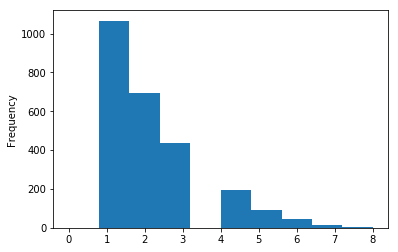

In [53]:
## De los tocados:
print("Promedio de no aceptados:",base_union_nov['num_no_aceptado'].mean())
base_union_nov['num_no_aceptado'].plot.hist()